# **Sistem Rekomendasi Barang Jualan (CNN)**


### Mengimpor library

In [ ]:
import numpy as np 
import pandas as pd
import cv2
import zipfile
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf
import datetime, os
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import layers
from tensorflow.keras import Model
from keras import models

%matplotlib inline

### Penggunaan Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadwafiyulloh","key":"a28f7a0ed6b974623c4efd744a538064"}'}

### Pengaksesan Dataset

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download muhammadwafiyulloh/fashiondatasetfiltered

 97% 70.0M/72.2M [00:03<00:00, 31.0MB/s]
100% 72.2M/72.2M [00:03<00:00, 22.0MB/s]


In [ ]:
local_zip = '/content/fashiondatasetfiltered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!ls '/content/'

 fashiondatasetfiltered.zip  'filtered images'	 sample_data
 FASHION-DATASET-SMALL	      kaggle.json


### Menampilkan Direktori

In [ ]:
DATASET_PATH = "/content/"
print(os.listdir(DATASET_PATH))

['.config', 'fashiondatasetfiltered.zip', 'filtered images', 'FASHION-DATASET-SMALL', 'kaggle.json', 'sample_data']


### Persiapan Dataset

In [ ]:
base_dir = DATASET_PATH + '/FASHION-DATASET-SMALL/'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')
input_size = 150

train_datagen = ImageDataGenerator(rescale = 1./255.)
                                  #  ,
                                  #  zoom_range = 0.2,
                                  #  horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1./255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 128,
                                                    class_mode='sparse',
                                                    target_size = (input_size, input_size))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size = 128,
                                                          class_mode  = 'sparse', 
                                                          target_size = (input_size, input_size))

Found 5003 images belonging to 111 classes.
Found 589 images belonging to 111 classes.


### Persiapan Pre-Trained Model

In [ ]:
# Download pre-trained weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-03 09:49:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   116MB/s    in 0.7s    

2022-06-03 09:49:20 (116 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# menyimpan weight file 
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Inisialisasi model
# menyetel ukuran masukkan gambar
pre_trained_model = InceptionV3(input_shape = (input_size, input_size, 3), 
                                include_top = False, 
                                weights = None)

# mengisi weight pre-trained model
pre_trained_model.load_weights(local_weights_file)

# freeze weight pada layer
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [ ]:
# Pemilihan layer terakhir sebagai model dasar
base_model = pre_trained_model.get_layer('mixed5')
print('output dari based model: ', base_model.output_shape)
base_model_output = base_model.output

last layer output shape:  (None, 7, 7, 768)


### Perancangan Model CNN

In [ ]:
def create_model():
    # model = tf.keras.models.Sequential([
    #         tf.keras.layers.Conv2D(32, (3, 3), input_shape = (input_size,input_size,3), activation='relu'),
    #         tf.keras.layers.MaxPooling2D((2,2)),
    #         tf.keras.layers.Dropout(0.2),

    #         tf.keras.layers.Conv2D(64, (3, 3), input_shape = (input_size, input_size,3), activation='relu'),
    #         tf.keras.layers.MaxPooling2D((2,2)),
    #         tf.keras.layers.Dropout(0.2),

    #         tf.keras.layers.Conv2D(128, (3, 3), input_shape = (input_size,input_size,3), activation='relu'),
    #         tf.keras.layers.MaxPooling2D((2,2)),
    #         tf.keras.layers.Dropout(0.2),
    #         last_output,
    #         tf.keras.layers.Flatten(),
    #         tf.keras.layers.Dense(512, activation = "relu"),
    #         # tf.keras.layers.Dropout(0.3),
    #         tf.keras.layers.Dense(111, activation= "softmax")
    # ])

    model = layers.Flatten()(base_model_output)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)                  
    model = layers.Dense(111, activation= "softmax")(model)           

    model = Model(pre_trained_model.input, model) 

    return model


In [ ]:
model=create_model()
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
model.compile(
    loss ='sparse_categorical_crossentropy', 
    optimizer = 'adam',
    metrics =['accuracy'])

### Callback untuk Menghentikan Training

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95) and (logs.get('val_accuracy') > 0.85):
      print("\nTraining model dihentikan!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs=150, 
    verbose = 2,
    callbacks=callbacks)

Epoch 1/150

Training model dihentikan!
40/40 - 133s - loss: 0.0566 - accuracy: 0.9800 - val_loss: 1.1272 - val_accuracy: 0.8778 - 133s/epoch - 3s/step


### Evaluasi Model

<Figure size 432x288 with 0 Axes>

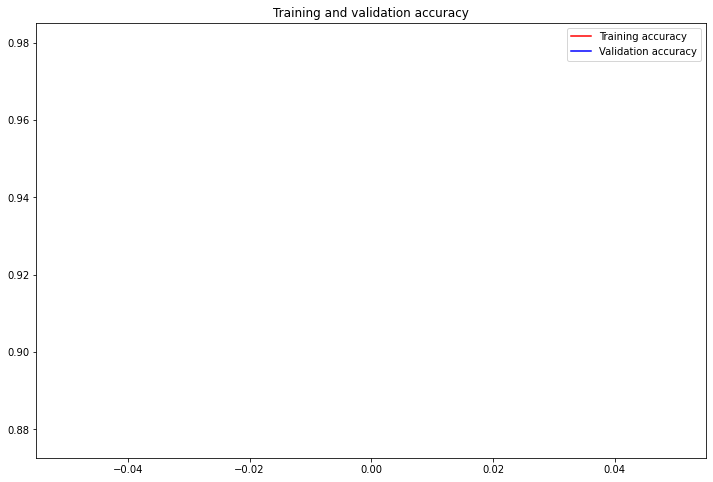

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

In [ ]:
! rm -r '/content/Recommendation_System.h5'

rm: cannot remove '/content/Recommendation_System.h5': No such file or directory


In [ ]:
# save model
model.save('Recommendation_System_CNN.h5')

In [ ]:
# load model
model = models.load_model('Recommendation_System_CNN.h5')

### Prediksi gambar yang diberikan

In [ ]:
# mengetahui jumlah class
fashion_class = []
for c in os.listdir(DATASET_PATH + 'filtered images/'): 
  c = c.split('.')
  fashion_class.append(c[0])
fashion_class = list(dict.fromkeys(fashion_class))
fashion_class.sort()

print(fashion_class)
print(len(fashion_class))

['Accessory Gift Set', 'Baby Dolls', 'Backpacks', 'Bangle', 'Bath Robe', 'Beauty Accessory', 'Belts', 'Blazers', 'Boxers', 'Bra', 'Bracelet', 'Briefs', 'Camisoles', 'Capris', 'Caps', 'Casual Shoes', 'Churidar', 'Clutches', 'Compact', 'Deodorant', 'Dresses', 'Duffel Bag', 'Dupatta', 'Earrings', 'Eye Cream', 'Eyeshadow', 'Face Moisturisers', 'Face Scrub and Exfoliator', 'Face Wash and Cleanser', 'Flats', 'Flip Flops', 'Footballs', 'Formal Shoes', 'Foundation and Primer', 'Fragrance Gift Set', 'Free Gifts', 'Gloves', 'Handbags', 'Headband', 'Heels', 'Highlighter and Blush', 'Innerwear Vests', 'Jackets', 'Jeans', 'Jewellery Set', 'Jumpsuit', 'Kajal and Eyeliner', 'Kurta Sets', 'Kurtas', 'Kurtis', 'Laptop Bag', 'Leggings', 'Lip Care', 'Lip Gloss', 'Lip Liner', 'Lipstick', 'Lounge Pants', 'Lounge Shorts', 'Lounge Tshirts', 'Mask and Peel', 'Messenger Bag', 'Mobile Pouch', 'Mufflers', 'Nail Essentials', 'Nail Polish', 'Necklace and Chains', 'Night suits', 'Nightdress', 'Patiala', 'Pendant', '

In [ ]:
def prediction(img):
    resized_img = cv2.resize(img, dsize=(input_size, input_size), interpolation = cv2.INTER_AREA)
    print(resized_img.shape)
    plt.imshow(resized_img)
    
    x_data = np.array(img).reshape(-1,input_size, input_size,3)
    x_data=x_data/255
    res=model.predict(x_data)

    print(np.argmax(res))
    return x_data,fashion_class[np.argmax(res)]

> #### Prediksi Gambar dari Dataset

Earrings.43795.jpg
Prediction: 
(150, 150, 3)
23
Earrings


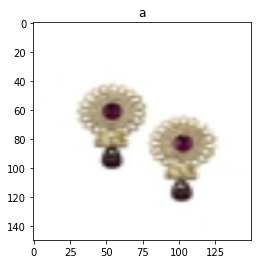

In [ ]:
i = 4000
Image_path= DATASET_PATH + 'filtered images/' 
image_point = os.listdir(Image_path)[i]
imageid = image_point.split('.')
imageid = image_point[1]

image = cv2.imread(Image_path + str(image_point),cv2.IMREAD_COLOR)
realIm = cv2.resize(image, dsize=(input_size, input_size))
realIm=cv2.cvtColor(realIm,cv2.COLOR_BGR2RGB)

print(image_point)
plt.title(imageid)
plt.imshow(realIm)

print('Prediction: ')
numpyIm,class_image=prediction(realIm)
print(class_image)
# print(numpyIm)

> #### Prediksi Gambar dari Sumber Berbeda

Saving Screenshot 2022-06-04 000939.png to Screenshot 2022-06-04 000939.png
(150, 150, 3)
104
Tshirts


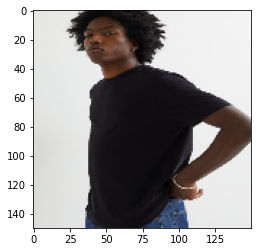

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
Image_path= DATASET_PATH + 'filtered images/' 

for fn in uploaded.keys():
  path = fn
  img = cv2.imread(path,cv2.IMREAD_COLOR)
  img = cv2.resize(img, dsize=(input_size, input_size))
  plt.imshow(img)
  realIm = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  numpyIm,class_image=prediction(realIm)
  print(class_image)
  # print(numpyIm)

In [ ]:
# ! ls '/content/'
for i in os.listdir('/content/'):
  if i.endswith('.JPG') or i.endswith('.png') or i.endswith('.jpg'):
    os.remove('/content/'+ i)

### Mengecek Kesamaan Berdasarkan Kategori Pakaian

In [ ]:
X_match=[]
X_filename_match=[]
X_numpy=[]
filterIm = os.listdir(DATASET_PATH + 'filtered images/')

for image in filterIm:
    imagelist = image.split('.')
    imPointed = imagelist[0]
    if class_image == imPointed:
      im = cv2.imread(DATASET_PATH + 'filtered images/' + str(image))
      resizedIm = cv2.resize(im, dsize=(input_size,input_size))
      
      X_match.append(resizedIm)
      X_filename_match.append(image)
X_numpy = np.array(X_match).reshape(-1, input_size,input_size,3)
X_numpy = X_numpy/255

In [ ]:
for i in X_match:
  plt.imshow(X_match[0])
plt.title(X_filename_match[0])

### Sistem Merekomendasikan Barang

In [ ]:
def VectorDistances(i1, i2):
    return math.sqrt(np.sum((i1-i2)**2))

In [ ]:
distList=[]
for i in range (0, len(X_numpy)):
    distList.append(VectorDistances(numpyIm,X_numpy[i]))

print(distList)
distancesSorted = distList.sort()

best_distances=distancesSorted[0:10]
best_distances = list(dict.fromkeys(best_distances))

distIndex=[]
for i in range (0, len(best_distances)):
  distIndex.append(distList.index(best_distances[i]))

print(distIndex)

In [ ]:

plt.title(imageid)
plt.imshow(realIm)

fig=plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
axis=[]
for i in range(0,len(distIndex)):
    print(X_filename_match[i])
    Image_path= DATASET_PATH + 'filtered images/'+str(X_filename_match[distIndex[i]])
    src = cv2.imread(Image_path)
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 

    axis.append(fig.add_subplot(1,5, i+1))
    subplot_title=str(X_filename_match[distIndex[i]])
    axis[-1].set_title(subplot_title)  
    plt.imshow(image)

fig.tight_layout()
plt.show()
    